# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

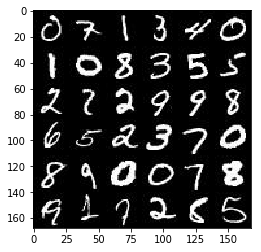

In [3]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

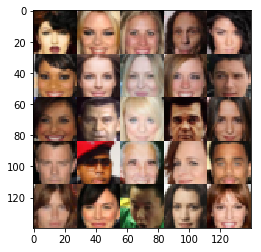

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [76]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [124]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, filters=64, kernel_size=5,  strides = 2, activation=None, padding='SAME')
        conv1 = tf.maximum(conv1 * alpha, conv1)
        
        conv2 = tf.layers.conv2d(conv1, filters=128, kernel_size=5, strides = 2, activation=None, padding='SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(conv2 * alpha, conv2)
        
        conv3 = tf.layers.conv2d(conv2, filters=256, kernel_size=5, strides = 2, activation=None, padding='SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(conv3 * alpha, conv3)

        
        fc = tf.reshape(conv3, (-1, (4*4*256)))
        logits = tf.layers.dense(fc, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [131]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        
        fclayer = tf.layers.dense(z, 3*3*1024)
        
        fclayer = tf.reshape(fclayer, (-1, 3, 3, 1024))
        fclayer = tf.layers.batch_normalization(fclayer, training=is_train)
        fclayer = tf.maximum(alpha * fclayer, fclayer)
        
        conv2 = tf.layers.conv2d_transpose(fclayer, filters = 512, kernel_size = 3, strides = 2, activation=None, padding='VALID')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #print(conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, filters = 256, kernel_size = 5, strides = 2, activation=None, padding='SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
      
        logits = tf.layers.conv2d_transpose(conv3, filters = out_channel_dim, kernel_size = 5, strides = 2, activation=None, padding='SAME')
        #conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        #conv2 = tf.maximum(alpha * conv1, conv1)
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [132]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_images = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(gen_images, reuse=True)
    

    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real))) 
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake))) 
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake))) 
    
    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [133]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]

    # what does this with do?
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [134]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [137]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # is below bad?

    
    #if(data_image_mode ==  "RGB"):
        #depth = 3
    #else: #L
     #   depth = 1
    
    # model_inputs(image_width, image_height, image_channels, z_dim):
    #real_inputs, z_inputs, learning_rate
    #60000, 28, 28, 1
    # what is z_dim?
    #print(data_shape)
    real_inputs, z_inputs, lrn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    #return d_loss_real + d_loss_fake, g_loss
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[3])

    #return d_train_opt, g_train_opt
    d_opt, g_opt = model_opt(d_loss, g_loss, lrn_rate, beta1)
    sample_z = tf.constant(np.random.uniform(-1, 1, size=(25, z_dim)), dtype=tf.float32)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                #-1 to 1 or 0.5?
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print(batch_z)

                # Run optimizers
                # discriminator(images, reuse=False):
                # generator(z, out_channel_dim, is_train=True):
                
                _ = sess.run(d_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lrn_rate: learning_rate })
                _ = sess.run(g_opt, feed_dict={z_inputs: batch_z, real_inputs: batch_images, lrn_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    #d_loss, g_loss = model_loss()
                    #(input_real, input_z, out_channel_dim):
                    train_loss_d = d_loss.eval({real_inputs: batch_images, z_inputs: batch_z})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    #(sess, n_images, input_z, out_channel_dim, image_mode):
                    show_generator_output(sess, 25, sample_z, data_shape[3], data_image_mode)
        #print one last time at end of training
        show_generator_output(sess, 25, sample_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.4118
Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 0.8152
Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 2.1403
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 0.8060... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 0.7478... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 0.8846... Generator Loss: 1.0787
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 0.7714


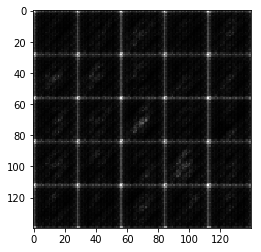

Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 1.0392
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 1.9202
Epoch 1/2... Discriminator Loss: 0.9687... Generator Loss: 1.1887
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 1.3643
Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 0.5555
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 1.9446
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 1.0167
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.8088


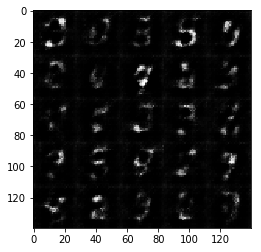

Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 1.0655
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.9248
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 1.2735
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 1.3273
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 0.8690
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 0.7335
Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 0.9315


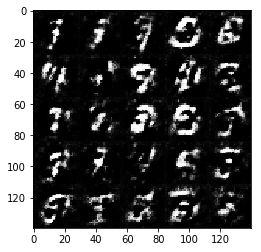

Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 0.8308... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.3941
Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 1.4594
Epoch 1/2... Discriminator Loss: 0.7060... Generator Loss: 1.3518
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 1.6750
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.0362
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 1.4953
Epoch 1/2... Discriminator Loss: 0.8984... Generator Loss: 0.7962


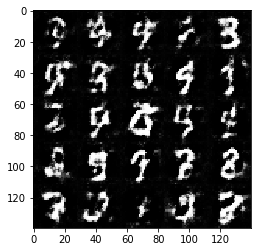

Epoch 1/2... Discriminator Loss: 0.8031... Generator Loss: 1.4531
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 1.4372
Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 1.1225
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.8259
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 0.5717
Epoch 1/2... Discriminator Loss: 0.7394... Generator Loss: 1.2606
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 0.8171
Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 1.4303
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 1.1620
Epoch 1/2... Discriminator Loss: 0.8098... Generator Loss: 1.3221


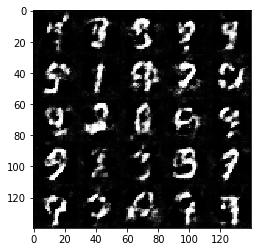

Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 1.2941
Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.7727
Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 0.4950
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.8298
Epoch 1/2... Discriminator Loss: 0.7703... Generator Loss: 1.3681
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 0.5596
Epoch 1/2... Discriminator Loss: 0.7802... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.0636
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 0.9766


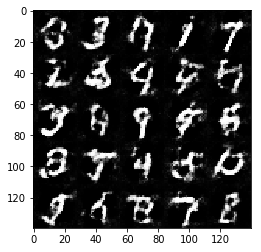

Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.3663
Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 1.1659
Epoch 1/2... Discriminator Loss: 0.8822... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 1.6004
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 1.9192
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 1.7687
Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 0.3543
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 0.9232... Generator Loss: 0.7374


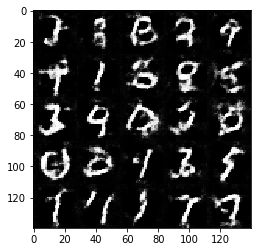

Epoch 1/2... Discriminator Loss: 0.8169... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 1.5081
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 1.7911
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 1.1034


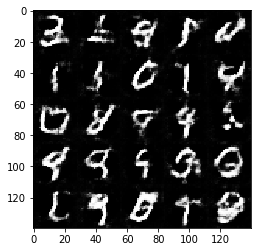

Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.2139
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 1.6695
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.7788
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.3988
Epoch 1/2... Discriminator Loss: 0.8166... Generator Loss: 1.0079
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.4951
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 0.8706


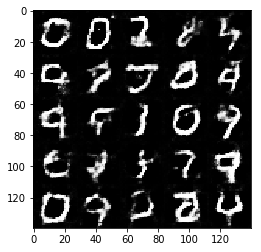

Epoch 1/2... Discriminator Loss: 0.9309... Generator Loss: 0.8739
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 0.8871... Generator Loss: 1.5392
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.2965
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 1.3350
Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.1736
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.5050


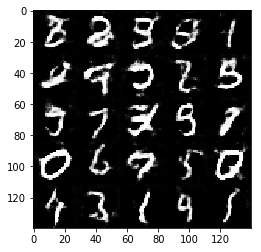

Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 0.8198
Epoch 2/2... Discriminator Loss: 1.1700... Generator Loss: 0.5312
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 1.4768
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 1.5175
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 1.0823
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 1.6492
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.5760
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.3681


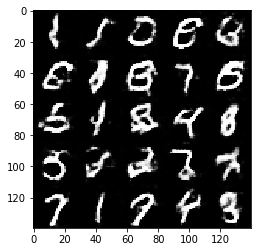

Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 1.6401
Epoch 2/2... Discriminator Loss: 0.9398... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 0.8898... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 0.4691
Epoch 2/2... Discriminator Loss: 0.9299... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 0.5476


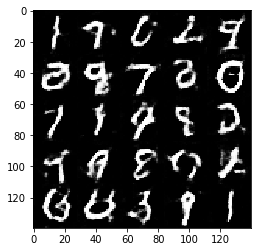

Epoch 2/2... Discriminator Loss: 0.9063... Generator Loss: 0.9795
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 1.0950
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 1.5703
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 0.6473
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 1.2999
Epoch 2/2... Discriminator Loss: 1.0787... Generator Loss: 0.6012


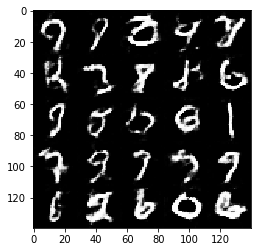

Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 1.5233
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.4423
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 0.6664
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 1.4507
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 1.3366
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 0.9530... Generator Loss: 1.2455
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.5929
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.4259


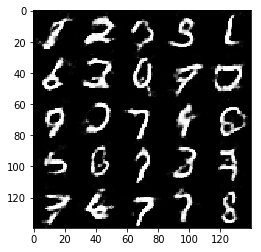

Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 1.9010
Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 1.0239
Epoch 2/2... Discriminator Loss: 1.5285... Generator Loss: 0.3187
Epoch 2/2... Discriminator Loss: 0.9765... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 2.1122
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 1.0915
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 1.5075
Epoch 2/2... Discriminator Loss: 0.8313... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.7266


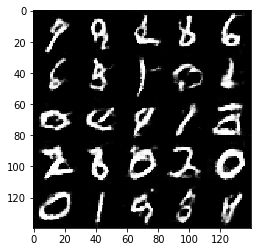

Epoch 2/2... Discriminator Loss: 1.4931... Generator Loss: 0.3484
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.0688
Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 1.7314
Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 0.4625
Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 1.8470
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 0.6189
Epoch 2/2... Discriminator Loss: 0.7758... Generator Loss: 1.6270
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 0.4954


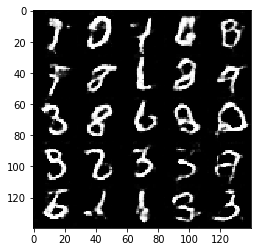

Epoch 2/2... Discriminator Loss: 0.9407... Generator Loss: 0.7092
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 2.4263
Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 1.0926
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.0339
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 0.8205
Epoch 2/2... Discriminator Loss: 1.8998... Generator Loss: 2.8559
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.1433
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 0.9118


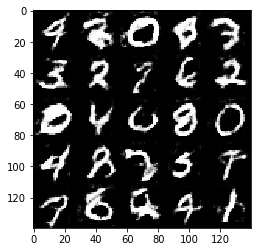

Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 1.0964
Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 0.6435
Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 0.9336
Epoch 2/2... Discriminator Loss: 0.9051... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 0.5361
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 1.7447... Generator Loss: 3.2348
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 0.7042


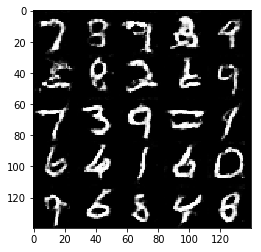

Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.0218
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 0.8551... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.1790
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.2399
Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.5712


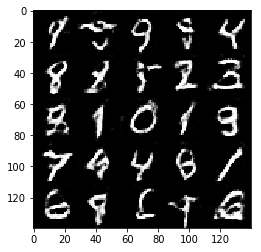

In [138]:
batch_size = 64
z_dim = 100
learning_rate = .0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4716... Generator Loss: 0.2009
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.1186
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 1.4934
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 1.4689
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.4798
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 3.0765
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6561


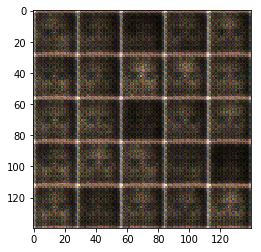

Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.4415
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.6901


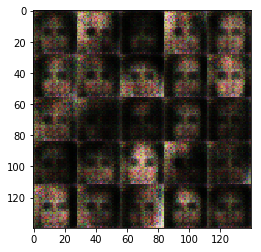

Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.5468


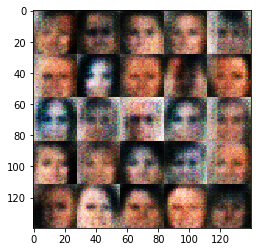

Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 1.4437
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.7733
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.9936
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.3116


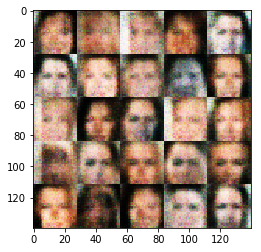

Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.3575
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.3092
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.4879
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 2.0060
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.4136


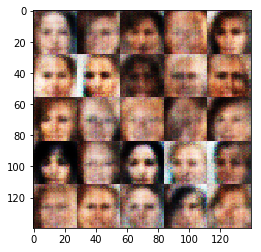

Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.5048
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 1.6657... Generator Loss: 0.3045
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.8438


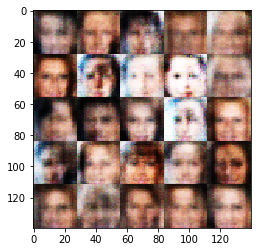

Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.8060... Generator Loss: 0.2748
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8858


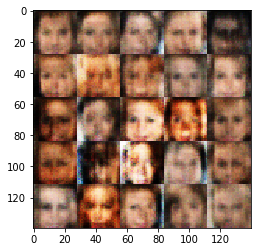

Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.9892


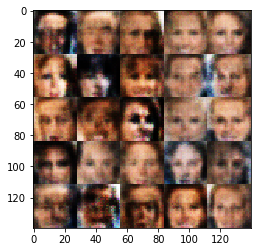

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.4457
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 1.2992
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 1.5234
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.0449


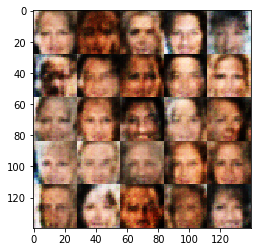

Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.7291... Generator Loss: 0.3179
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.9217
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.1261


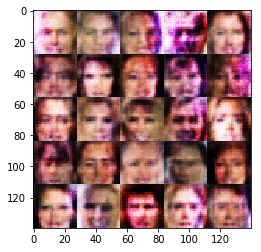

Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.3015
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 2.3779
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.3947
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.7430


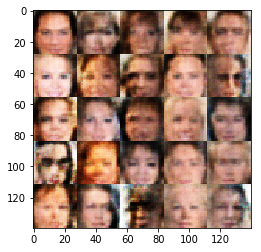

Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.6796
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 2.2423
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.6154
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.1225
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 2.4313
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.0642


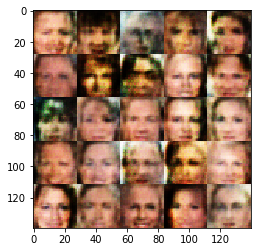

Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.3475
Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 0.3011
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.9013... Generator Loss: 0.2280
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.7961


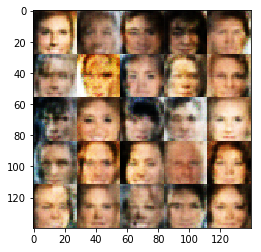

Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.5729
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.4300
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.8019
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.7310


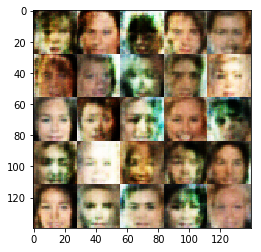

Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.3714
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.3705
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.3444


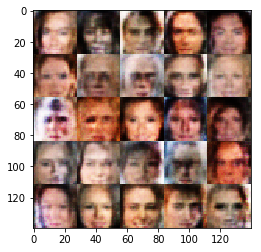

Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.6833... Generator Loss: 0.2927
Epoch 1/1... Discriminator Loss: 1.8761... Generator Loss: 0.2327
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.5665


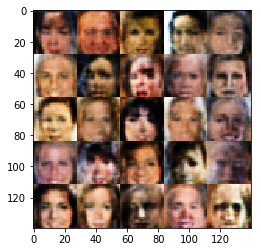

Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.7623
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.3307
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 0.3233
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.4835


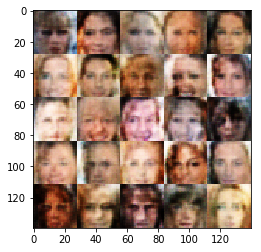

Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.9743... Generator Loss: 0.2033
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.6519... Generator Loss: 0.2889
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.6038


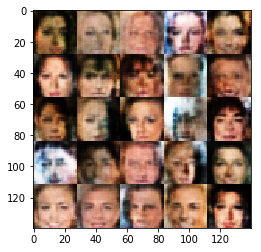

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 2.0457
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 1.7450... Generator Loss: 0.2924
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.0375


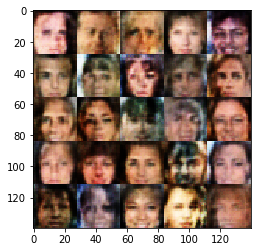

Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.6439
Epoch 1/1... Discriminator Loss: 1.6847... Generator Loss: 0.2748
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.8031
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.3256


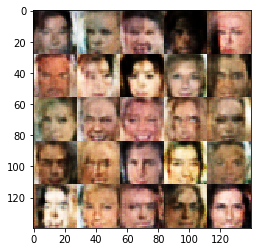

Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 2.0116... Generator Loss: 0.1960
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.2035


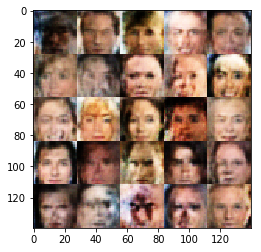

Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 2.2857
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 2.3508
Epoch 1/1... Discriminator Loss: 2.0227... Generator Loss: 0.1949
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 1.5074


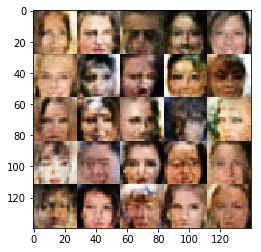

Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 1.6526
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.6944


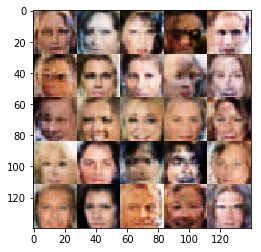

Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.3387
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.9673
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.9445
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.9758


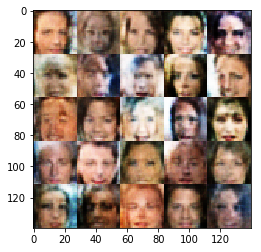

Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.9962... Generator Loss: 0.1953
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.5964


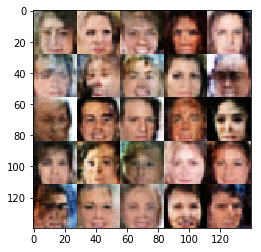

Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.5668
Epoch 1/1... Discriminator Loss: 1.7880... Generator Loss: 0.2774
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.0926


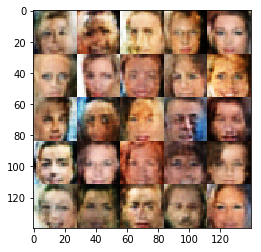

Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 2.0691... Generator Loss: 0.1959
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.4861
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.6180


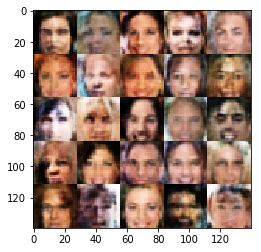

Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.7716
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.3229
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.7797
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.1994


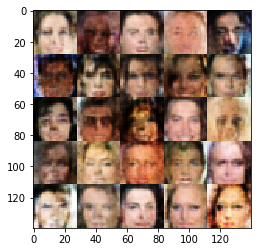

Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 1.7996
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.4744


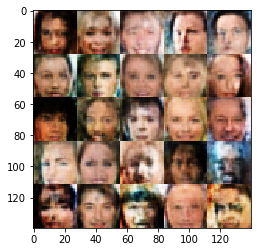

Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.9710
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.6495


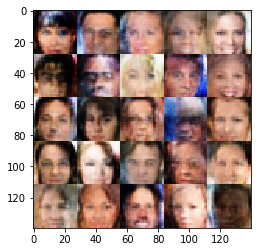

Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.5447


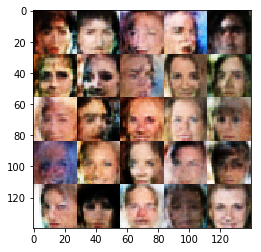

Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.8654
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.5756


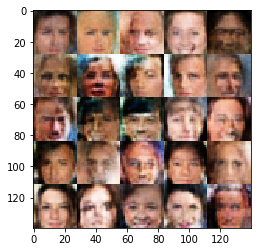

In [139]:
batch_size = 64
z_dim = 100
learning_rate = .0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.